# Solving CartPole with Dueling Double Deep Q Network
From this tutorial: [https://pylessons.com/CartPole-DDDQN](https://pylessons.com/CartPole-DDDQN)

In [5]:
import os
import gymnasium as gym
import random
import numpy as np

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Add
from keras.optimizers import Adam, RMSprop

from collections import deque
import matplotlib.pyplot as plt

In [2]:
def OurModel(input_shape, action_space, dueling=False):
    x_input = Input(input_shape)

    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    x = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(x_input)

    # Hidden layer with 256 nodes
    x = Dense(256, activation="relu", kernel_initializer='he_uniform')(x)

    # Hidden layer with 64 nodes
    x = Dense(64, activation="relu", kernel_initializer='he_uniform')(x)

    if dueling:
        state_value = Dense(1, kernel_initializer="he_uniform")(x)
        state_value = Lambda(lambda s: tf.expand_dims(s[:,0], -1), output_shape=(action_space,))(state_value)

        action_advantage = Dense(action_space, kernel_initializer="he_uniform")(x)
        action_advantage = Lambda(lambda a: a[:, :] - tf.reduce_mean(a[:, :], keepdims=True), output_shape=(action_space,))(action_advantage)

        x = Add()([state_value, action_advantage])
    else:
        # Output Layer with # of actions: 2 nodes (left, right)
        x = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(x)

    model = Model(inputs = x_input, outputs = x)
    model.compile(loss="mse", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

In [3]:
class DQNAgent:
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.env.spec.max_episode_steps = 4000

        # By default cartpole-v1 has max episode steps = 500
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.MAX_EPISODES = 1000
        self.memory = deque(maxlen=2000)

        self.GAMMA = 0.95
        self.epsilon = 1.0
        self.EPSILON_MIN = 0.01
        self.EPSILON_DECAY = 0.999
        self.BATCH_SIZE = 32

        self.TRAIN_START = 1000

        self.TAU = 0.1 # Target network soft update hyperparameter

        self.ddqn = True
        self.soft_update = False # Use Soft update to update the target network?
        self.dueling = True # Use dueling network

        self.save_path = 'models'
        self.scores, self.episodes, self.averages = [], [], []

        if self.ddqn:
            if self.dueling:
                print("---------Dueling Double DQN---------")
                self.model_name = os.path.join(self.save_path, "Dueling_DDQN_CartPole-v1.h5")
            else:
                print("---------Double DQN---------")
                self.model_name = os.path.join(self.save_path, "DDQN_CartPole-v1.h5")
        else:
            print("---------Standard DQN---------")
            self.model_name = os.path.join(self.save_path, "DQN_CartPole-v1.h5")

        # Create model
        self.model = OurModel(input_shape=(self.state_size, ), action_space=self.action_size, dueling=self.dueling)
        self.target_model = OurModel(input_shape=(self.state_size, ), action_space=self.action_size, dueling=self.dueling)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        # Decay epsilon after training started
        if len(self.memory) > self.TRAIN_START:
            if self.epsilon > self.EPSILON_MIN:
                self.epsilon *= self.EPSILON_DECAY

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state, verbose=0))

    def replay(self):
        # Do not train the network is training did not started
        if len(self.memory) < self.TRAIN_START:
            return

        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, self.BATCH_SIZE)

        state = np.zeros((self.BATCH_SIZE, self.state_size))
        next_state = np.zeros((self.BATCH_SIZE, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.BATCH_SIZE):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # Batch prediction to save speed
        target = self.model.predict(state, verbose=0)
        target_next = self.model.predict(next_state, verbose=0)
        target_val = self.target_model.predict(next_state, verbose=0)

        for i in range(self.BATCH_SIZE):
            # Correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                if self.ddqn:
                    # Double DQN (with slight variation by predicting next state using both main and target network)
                    a = np.argmax(target_next[i])
                    target[i][action[i]] = reward[i] + self.GAMMA * (target_val[i][a])
                else:
                    # Standard DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = reward[i] + self.GAMMA * (np.amax(target_next[i]))

        # Train the neural network
        self.model.fit(state, target, batch_size=self.BATCH_SIZE, verbose=0)

    def update_target_model(self):
        if not self.soft_update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
        if self.soft_update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    plt.figure(figsize=(18, 9))
    def plot_model(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.averages.append(sum(self.scores[-50:]) / len(self.scores[-50:]))

        plt.plot(self.episodes, self.averages, 'r')
        plt.plot(self.episodes, self.scores, 'b')
        plt.ylabel('Score', fontsize=18)
        plt.ylabel('Steps', fontsize=18)

        dqn = "DQN_"
        soft_update = ""
        dueling = ""

        if self.ddqn: dqn = 'DDQN_'
        if self.soft_update: soft_update = '_soft'
        if self.dueling: dueling = '_Dueling'

        try:
            plt.savefig(dqn + "CartPole-v1" + soft_update + dueling + ".png")
        except OSError:
            pass

        return str(self.averages[-1])[:5]

    def load(self, name):
        self.model = tf.keras.models.load_model(name)

    def save(self, name):
        self.model.save(name)

    def run(self):
        for episode in range(self.MAX_EPISODES):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                #self.env.render()
                action = self.act(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env.spec.max_episode_steps -1:
                    reward = reward
                else:
                    reward = -100

                self.remember(state, action, reward, next_state, done)

                state = next_state
                i += 1

                if done:
                    # Every episode, update target model
                    self.update_target_model()

                    average = self.plot_model(i, episode)

                    print(f"Episode: {episode}/{self.MAX_EPISODES}, score: {i}, epsilon: {self.epsilon:.2}, average: {average}")
                    if i == self.env.spec.max_episode_steps:
                        print("Saving trained model...")
                        self.save(self.model_name)
                        return

                self.replay()


    def test(self):
        self.load(self.model_name)
        for e in range(self.MAX_EPISODES):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.MAX_EPISODES, i))
                    break

<Figure size 1800x900 with 0 Axes>

---------Dueling Double DQN---------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 512)          2560        ['input_2[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 256)          131328      ['dense_4[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 64)           16448       ['dense_5[0][0]']                
                                                         

/home/deewens/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Episode: 0/1000, score: 16, epsilon: 1.0, average: 16.0
Episode: 1/1000, score: 19, epsilon: 1.0, average: 17.5
Episode: 2/1000, score: 14, epsilon: 1.0, average: 16.33
Episode: 3/1000, score: 13, epsilon: 1.0, average: 15.5
Episode: 4/1000, score: 18, epsilon: 1.0, average: 16.0
Episode: 5/1000, score: 27, epsilon: 1.0, average: 17.83
Episode: 6/1000, score: 15, epsilon: 1.0, average: 17.42
Episode: 7/1000, score: 15, epsilon: 1.0, average: 17.12
Episode: 8/1000, score: 10, epsilon: 1.0, average: 16.33
Episode: 9/1000, score: 29, epsilon: 1.0, average: 17.6
Episode: 10/1000, score: 9, epsilon: 1.0, average: 16.81
Episode: 11/1000, score: 11, epsilon: 1.0, average: 16.33
Episode: 12/1000, score: 28, epsilon: 1.0, average: 17.23
Episode: 13/1000, score: 25, epsilon: 1.0, average: 17.78
Episode: 14/1000, score: 41, epsilon: 1.0, average: 19.33
Episode: 15/1000, score: 40, epsilon: 1.0, average: 20.62
Episode: 16/1000, score: 26, epsilon: 1.0, average: 20.94
Episode: 17/1000, score: 26, e

KeyboardInterrupt: 

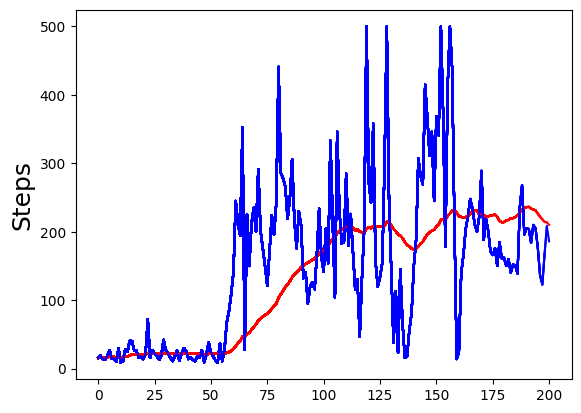

In [6]:
agent = DQNAgent()
agent.run()